# We are going to enter 'Paddy Doctor: Paddy Disease Classification'

<a href="https://www.kaggle.com/competitions/paddy-disease-classification">Paddy disease</a> Here is the competition

Go to the competition data page and <b>agree to the terms of service</b>. Once you do that you can get data and submit results. At the bottom of the page there is a kaggle CLI link to download the data, after installing the CLI (see below) get this link and run it.

# Kaggle CLI: Install and set up auth token

This makes it really easy to get data and submit results.  Plus it makes it easy to automate tedious stuff (like downloading data)<br>


In [3]:
#first ensure kaggle is installed
#will have to run this everytime unless pip install --user kaggle, but then may run into problems when using ctags to index the fastai user library
try:
    import kaggle
except ModuleNotFoundError:
    #not there install
    !pip install kaggle

#if kaggle is installed but you dont have key installed then importing kaggle will throw an exception
#so upload key (verify it's permissions BTW)
!chmod 600 /root/.kaggle/kaggle.json

## Constants and some useful functions

In [4]:
TRAIN_DIR = './train_images'
TEST_DIR='./test_images'
NUMB_OUTPUT_CLASSES_TO_PREDICT=10
BATCH_SIZE=128

#!pip install pynvml
import gc
import torch
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()
report_gpu()

#run this in another terminal window to see what is happenning 
#to your gpu memory(assumming you have one).  It will update every 2 seconds
#watch nvidia-smi

GPU:0
no processes are running


## Kaggle CLI: Get the Data

In [5]:
#download data once
import os
if not os.path.exists(TRAIN_DIR):
    #get the data
    !kaggle competitions download -c paddy-disease-classification
    
    #unzip it, -q is silent
    !unzip -q paddy-disease-classification.zip
    
    #remove orig zip file (because its large)
    !rm paddy-disease-classification.zip

    #it put it all in /notebooks, thats fine if you dont mind importing it every time you start a machine 
    #(it's pretty fast though so why not?) Otherwise move it to storage and symlink it back, if you do this 
    #keep in mind you are permanetly taking up 1GB of your allocated 20GB of space

## Explore data

Notice that train_images has 10 folders, each with a picture of rice with a type of disease
<br><b>But test_images has no folders. That's because you have to determine which label to apply to each image

In [6]:
#what is train.csv?
import pandas as pd
df =pd.read_csv('train.csv')
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [7]:
#it has a list of all the training files and their labels
df.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

The dataset is imbalanced, easy to address (use a weighted dataloader in training) but beyond the scope of this course

Variety and age both have usefull info, but using them will complicate our model quite a bit, so we will ignore them for now.

### Turns out some of the images are different sizes, each batch has to have images the same size

see what the sizes are and remove the (640,480) images

In [8]:
from tqdm import tqdm
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [9]:
from fastcore.parallel import *

fls=get_image_files(TRAIN_DIR)
def f(o): return PILImage.create(o).size
sizes = parallel(f, fls, n_workers=6)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

### Remove them?  We could but what if the test set also has different sizes (it does)

Lets just resize them when needed

## OK Lets build a model

### First load the Data

Accomplished using dataloaders, a dataloader boils down to 2 parts: a dataset and a Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples

#### BTW Experimenting goes much (MUCH!) faster if you use a subset of original data

How about 50 of each?  Dataset size is roughly 100 then.  Not the same distribution as original dataset but faster to verify that things are working before we actually commit to the full dataset

In [10]:
#lets get 50 of each type
new_df = df.groupby('label').sample(n=50)
new_df

,image_id,label,variety,age
257,108855.jpg,bacterial_leaf_blight,ADT45,70
7,103051.jpg,bacterial_leaf_blight,ADT45,45
298,103033.jpg,bacterial_leaf_blight,ADT45,72
423,107907.jpg,bacterial_leaf_blight,KarnatakaPonni,50
109,104576.jpg,bacterial_leaf_blight,ADT45,55
...,...,...,...,...
9546,103538.jpg,tungro,ADT45,60
10126,108983.jpg,tungro,ADT45,70
9492,101899.jpg,tungro,ADT45,60
10341,106257.jpg,tungro,AtchayaPonni,57


#### Method 1- Load all data (using file system)

dataloaders are flexible, here I'm telling it where the images are and each folder name will be interpreted as the contained images label.



In [11]:
# if you dont have a valid_pct then you get a Nonetype object is non iterable error
# dls=ImageDataLoaders.from_folder('/notebooks/train_images',valid_pct=0.2)
dls=ImageDataLoaders.from_folder('/notebooks/train_images',valid_pct=0.2,item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))
# # dls.show_batch()
# dls.train_ds.items[:3]

#if you want to get rid of
# del(dls)
# report_gpu()

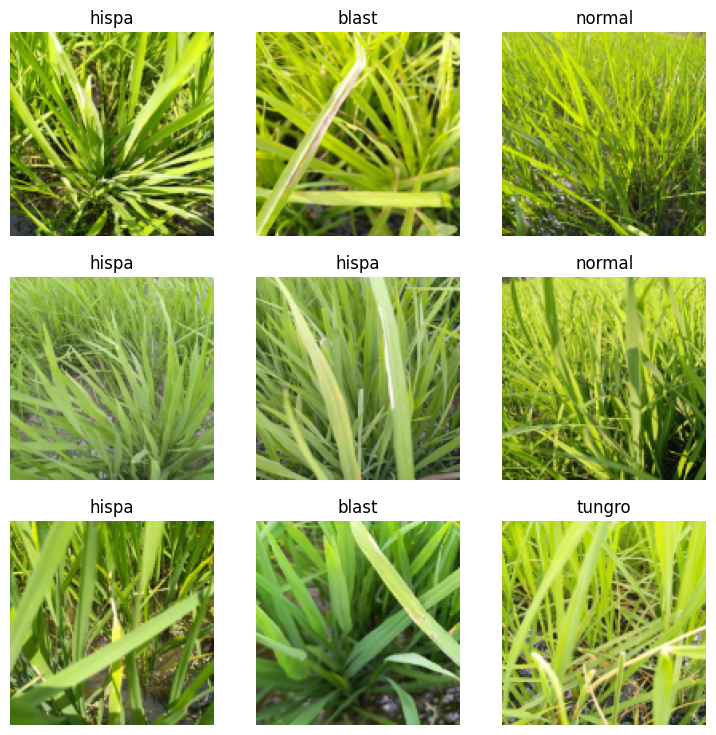

In [12]:
dls.show_batch()
# dls.train_ds.items[:3]

#### Method 2- Load all data using the .csv file

Maybe use a smaller dataset to verify training?

In [13]:
#create a new column which indicates where each image is located in TRAIN_DIR
df["loc"] = df['label'].astype(str) +"/"+ df["image_id"]
df

,image_id,label,variety,age,loc
0,100330.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100330.jpg
1,100365.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100365.jpg
2,100382.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100382.jpg
3,100632.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/100632.jpg
4,101918.jpg,bacterial_leaf_blight,ADT45,45,bacterial_leaf_blight/101918.jpg
...,...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55,tungro/107607.jpg
10403,107811.jpg,tungro,Zonal,55,tungro/107811.jpg
10404,108547.jpg,tungro,Zonal,55,tungro/108547.jpg
10405,110245.jpg,tungro,Zonal,55,tungro/110245.jpg


In [18]:
#when satisfied that things are set up properly, train on full dataset(df) instead of new_df
dls = ImageDataLoaders.from_df(df=df, #df=new_df or df
                               path=TRAIN_DIR, 
                               fn_col=4,
                               label_col=1,
                               suff='', #do not add extra .jpg
                               folder=".",
                              valid_pct=0.2,item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))
# dls.show_batch()

In [15]:
#clean up any memory that we can
report_gpu()

GPU:0
process     340068 uses     1806.000 MB GPU memory


### Next Choose a timm Model to Fine Tune

Which one though?  Look at <a href="https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning">The best vision models for fine-tuning</a>.  This notebook compares many different models which are fine-tuned on two differnt datasets;  <a href="https://www.robots.ox.ac.uk/~vgg/data/pets/"> Oxford IIT-Pet</a> and then <a href="https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data">Kaggle planet (space images)</a>.  

<mark>Choose a model with a low error rate and fit time (trains faster) on the type of data you are using.</mark>  For instance, if you want to build a dogs verses cats classifier, then choose a model that performed well when fine tuned on <a href="https://www.robots.ox.ac.uk/~vgg/data/pets/"> Oxford IIT-Pet</a>.

<b>BTW You want a pretrained model to fine tune on, so just look at the pretrained ones

In [16]:
#what 
import timm
# timm.list_models(pretrained=True)  #all models
timm.list_models(['*convnext_tiny*'],pretrained=True)  #pretrained convnext models

['convnext_tiny.fb_in1k',
 'convnext_tiny.fb_in22k',
 'convnext_tiny.fb_in22k_ft_in1k',
 'convnext_tiny.fb_in22k_ft_in1k_384',
 'convnext_tiny.in12k',
 'convnext_tiny.in12k_ft_in1k',
 'convnext_tiny.in12k_ft_in1k_384',
 'convnext_tiny_hnf.a2h_in1k']

### Now train the model

The model is wrapped in a learner object which also takes our dataloader

In [62]:
# Use vim -t vision_learner to see where fastai creates either a timm or a pytorch model

In [65]:
#this learner will use pytorches convnext_tiny (type convnext_tiny?? in cell to get location)
learn = vision_learner(dls, convnext_tiny, metrics=error_rate, path='.')
learn.fine_tune(2)
# learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.758164,0.863503,0.298414,00:22


epoch,train_loss,valid_loss,error_rate,time
0,1.010494,0.559483,0.187410,00:42
1,0.791422,0.469732,0.156655,00:42


In [67]:
#this learner will a timm model
learn = vision_learner(dls, 'convnext_tiny', metrics=error_rate, path='.')
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.655009,0.941539,0.301297,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.847646,0.558560,0.188852,00:43
1,0.521836,0.332379,0.107160,00:43
2,0.374064,0.274411,0.086497,00:43


In [68]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.381297,0.319452,0.099952,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.339009,0.284520,0.092263,00:42
1,0.254409,0.208069,0.068717,00:43
2,0.168276,0.163189,0.053820,00:43


In [70]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.334515,1.629001,0.567996,00:42
1,0.711429,0.653909,0.222970,00:42
2,0.325583,0.235135,0.072561,00:43


In [66]:
# check out what is happenning to GPU memory (watch nvidia-smi) is it being used?
#if we have a lot of extra memory then increase the batch size to increase training speed
#(rule of thumb: also increase learning rate by roughly square root of the batch size multiplier
# so if you quadruple batch size, multiply learning rate by 2)

### Can we optimize anything? Speed stuff up?

see how much gpu is being used nvidia-smi

how much memory is being used (install htop)

In [44]:
print(f'current batch size={dls.bs}, current learning rate={learn.lr}')

current batch size=128, current learning rate=0.0014


In [62]:
#increase batch size of images to go to the gpu at a time
dls.bs*=256

#increase model learning rate
learn.lr*=0.0014

turns out we are not really using much of our GPU, lets double the batch size and 1.4*lr

### Save model for later

In [25]:
#just save the model to weights dir (its pretty big)
#want to see how it works? Go to def of save (vim -t save) and find where it actualy saves the model (save_model function) 
learn.save('weights_only', with_opt=True)

Path('models/weights_only.pth')

In [28]:
learn.load('weights_only', with_opt=True)

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.0.weight", "0.1.weight", "0.1.bias", "0.1.running_mean", "0.1.running_var", "0.4.0.conv1.weight", "0.4.0.bn1.weight", "0.4.0.bn1.bias", "0.4.0.bn1.running_mean", "0.4.0.bn1.running_var", "0.4.0.conv2.weight", "0.4.0.bn2.weight", "0.4.0.bn2.bias", "0.4.0.bn2.running_mean", "0.4.0.bn2.running_var", "0.4.1.conv1.weight", "0.4.1.bn1.weight", "0.4.1.bn1.bias", "0.4.1.bn1.running_mean", "0.4.1.bn1.running_var", "0.4.1.conv2.weight", "0.4.1.bn2.weight", "0.4.1.bn2.bias", "0.4.1.bn2.running_mean", "0.4.1.bn2.running_var", "0.4.2.conv1.weight", "0.4.2.bn1.weight", "0.4.2.bn1.bias", "0.4.2.bn1.running_mean", "0.4.2.bn1.running_var", "0.4.2.conv2.weight", "0.4.2.bn2.weight", "0.4.2.bn2.bias", "0.4.2.bn2.running_mean", "0.4.2.bn2.running_var", "0.5.0.conv1.weight", "0.5.0.bn1.weight", "0.5.0.bn1.bias", "0.5.0.bn1.running_mean", "0.5.0.bn1.running_var", "0.5.0.conv2.weight", "0.5.0.bn2.weight", "0.5.0.bn2.bias", "0.5.0.bn2.running_mean", "0.5.0.bn2.running_var", "0.5.0.downsample.0.weight", "0.5.0.downsample.1.weight", "0.5.0.downsample.1.bias", "0.5.0.downsample.1.running_mean", "0.5.0.downsample.1.running_var", "0.5.1.conv1.weight", "0.5.1.bn1.weight", "0.5.1.bn1.bias", "0.5.1.bn1.running_mean", "0.5.1.bn1.running_var", "0.5.1.conv2.weight", "0.5.1.bn2.weight", "0.5.1.bn2.bias", "0.5.1.bn2.running_mean", "0.5.1.bn2.running_var", "0.5.2.conv1.weight", "0.5.2.bn1.weight", "0.5.2.bn1.bias", "0.5.2.bn1.running_mean", "0.5.2.bn1.running_var", "0.5.2.conv2.weight", "0.5.2.bn2.weight", "0.5.2.bn2.bias", "0.5.2.bn2.running_mean", "0.5.2.bn2.running_var", "0.5.3.conv1.weight", "0.5.3.bn1.weight", "0.5.3.bn1.bias", "0.5.3.bn1.running_mean", "0.5.3.bn1.running_var", "0.5.3.conv2.weight", "0.5.3.bn2.weight", "0.5.3.bn2.bias", "0.5.3.bn2.running_mean", "0.5.3.bn2.running_var", "0.6.0.conv1.weight", "0.6.0.bn1.weight", "0.6.0.bn1.bias", "0.6.0.bn1.running_mean", "0.6.0.bn1.running_var", "0.6.0.conv2.weight", "0.6.0.bn2.weight", "0.6.0.bn2.bias", "0.6.0.bn2.running_mean", "0.6.0.bn2.running_var", "0.6.0.downsample.0.weight", "0.6.0.downsample.1.weight", "0.6.0.downsample.1.bias", "0.6.0.downsample.1.running_mean", "0.6.0.downsample.1.running_var", "0.6.1.conv1.weight", "0.6.1.bn1.weight", "0.6.1.bn1.bias", "0.6.1.bn1.running_mean", "0.6.1.bn1.running_var", "0.6.1.conv2.weight", "0.6.1.bn2.weight", "0.6.1.bn2.bias", "0.6.1.bn2.running_mean", "0.6.1.bn2.running_var", "0.6.2.conv1.weight", "0.6.2.bn1.weight", "0.6.2.bn1.bias", "0.6.2.bn1.running_mean", "0.6.2.bn1.running_var", "0.6.2.conv2.weight", "0.6.2.bn2.weight", "0.6.2.bn2.bias", "0.6.2.bn2.running_mean", "0.6.2.bn2.running_var", "0.6.3.conv1.weight", "0.6.3.bn1.weight", "0.6.3.bn1.bias", "0.6.3.bn1.running_mean", "0.6.3.bn1.running_var", "0.6.3.conv2.weight", "0.6.3.bn2.weight", "0.6.3.bn2.bias", "0.6.3.bn2.running_mean", "0.6.3.bn2.running_var", "0.6.4.conv1.weight", "0.6.4.bn1.weight", "0.6.4.bn1.bias", "0.6.4.bn1.running_mean", "0.6.4.bn1.running_var", "0.6.4.conv2.weight", "0.6.4.bn2.weight", "0.6.4.bn2.bias", "0.6.4.bn2.running_mean", "0.6.4.bn2.running_var", "0.6.5.conv1.weight", "0.6.5.bn1.weight", "0.6.5.bn1.bias", "0.6.5.bn1.running_mean", "0.6.5.bn1.running_var", "0.6.5.conv2.weight", "0.6.5.bn2.weight", "0.6.5.bn2.bias", "0.6.5.bn2.running_mean", "0.6.5.bn2.running_var", "0.7.0.conv1.weight", "0.7.0.bn1.weight", "0.7.0.bn1.bias", "0.7.0.bn1.running_mean", "0.7.0.bn1.running_var", "0.7.0.conv2.weight", "0.7.0.bn2.weight", "0.7.0.bn2.bias", "0.7.0.bn2.running_mean", "0.7.0.bn2.running_var", "0.7.0.downsample.0.weight", "0.7.0.downsample.1.weight", "0.7.0.downsample.1.bias", "0.7.0.downsample.1.running_mean", "0.7.0.downsample.1.running_var", "0.7.1.conv1.weight", "0.7.1.bn1.weight", "0.7.1.bn1.bias", "0.7.1.bn1.running_mean", "0.7.1.bn1.running_var", "0.7.1.conv2.weight", "0.7.1.bn2.weight", "0.7.1.bn2.bias", "0.7.1.bn2.running_mean", "0.7.1.bn2.running_var", "0.7.2.conv1.weight", "0.7.2.bn1.weight", "0.7.2.bn1.bias", "0.7.2.bn1.running_mean", "0.7.2.bn1.running_var", "0.7.2.conv2.weight", "0.7.2.bn2.weight", "0.7.2.bn2.bias", "0.7.2.bn2.running_mean", "0.7.2.bn2.running_var". 
	Unexpected key(s) in state_dict: "0.model.conv1.weight", "0.model.bn1.weight", "0.model.bn1.bias", "0.model.bn1.running_mean", "0.model.bn1.running_var", "0.model.bn1.num_batches_tracked", "0.model.layer1.0.conv1.weight", "0.model.layer1.0.bn1.weight", "0.model.layer1.0.bn1.bias", "0.model.layer1.0.bn1.running_mean", "0.model.layer1.0.bn1.running_var", "0.model.layer1.0.bn1.num_batches_tracked", "0.model.layer1.0.conv2.weight", "0.model.layer1.0.bn2.weight", "0.model.layer1.0.bn2.bias", "0.model.layer1.0.bn2.running_mean", "0.model.layer1.0.bn2.running_var", "0.model.layer1.0.bn2.num_batches_tracked", "0.model.layer1.1.conv1.weight", "0.model.layer1.1.bn1.weight", "0.model.layer1.1.bn1.bias", "0.model.layer1.1.bn1.running_mean", "0.model.layer1.1.bn1.running_var", "0.model.layer1.1.bn1.num_batches_tracked", "0.model.layer1.1.conv2.weight", "0.model.layer1.1.bn2.weight", "0.model.layer1.1.bn2.bias", "0.model.layer1.1.bn2.running_mean", "0.model.layer1.1.bn2.running_var", "0.model.layer1.1.bn2.num_batches_tracked", "0.model.layer1.2.conv1.weight", "0.model.layer1.2.bn1.weight", "0.model.layer1.2.bn1.bias", "0.model.layer1.2.bn1.running_mean", "0.model.layer1.2.bn1.running_var", "0.model.layer1.2.bn1.num_batches_tracked", "0.model.layer1.2.conv2.weight", "0.model.layer1.2.bn2.weight", "0.model.layer1.2.bn2.bias", "0.model.layer1.2.bn2.running_mean", "0.model.layer1.2.bn2.running_var", "0.model.layer1.2.bn2.num_batches_tracked", "0.model.layer2.0.conv1.weight", "0.model.layer2.0.bn1.weight", "0.model.layer2.0.bn1.bias", "0.model.layer2.0.bn1.running_mean", "0.model.layer2.0.bn1.running_var", "0.model.layer2.0.bn1.num_batches_tracked", "0.model.layer2.0.conv2.weight", "0.model.layer2.0.bn2.weight", "0.model.layer2.0.bn2.bias", "0.model.layer2.0.bn2.running_mean", "0.model.layer2.0.bn2.running_var", "0.model.layer2.0.bn2.num_batches_tracked", "0.model.layer2.0.downsample.0.weight", "0.model.layer2.0.downsample.1.weight", "0.model.layer2.0.downsample.1.bias", "0.model.layer2.0.downsample.1.running_mean", "0.model.layer2.0.downsample.1.running_var", "0.model.layer2.0.downsample.1.num_batches_tracked", "0.model.layer2.1.conv1.weight", "0.model.layer2.1.bn1.weight", "0.model.layer2.1.bn1.bias", "0.model.layer2.1.bn1.running_mean", "0.model.layer2.1.bn1.running_var", "0.model.layer2.1.bn1.num_batches_tracked", "0.model.layer2.1.conv2.weight", "0.model.layer2.1.bn2.weight", "0.model.layer2.1.bn2.bias", "0.model.layer2.1.bn2.running_mean", "0.model.layer2.1.bn2.running_var", "0.model.layer2.1.bn2.num_batches_tracked", "0.model.layer2.2.conv1.weight", "0.model.layer2.2.bn1.weight", "0.model.layer2.2.bn1.bias", "0.model.layer2.2.bn1.running_mean", "0.model.layer2.2.bn1.running_var", "0.model.layer2.2.bn1.num_batches_tracked", "0.model.layer2.2.conv2.weight", "0.model.layer2.2.bn2.weight", "0.model.layer2.2.bn2.bias", "0.model.layer2.2.bn2.running_mean", "0.model.layer2.2.bn2.running_var", "0.model.layer2.2.bn2.num_batches_tracked", "0.model.layer2.3.conv1.weight", "0.model.layer2.3.bn1.weight", "0.model.layer2.3.bn1.bias", "0.model.layer2.3.bn1.running_mean", "0.model.layer2.3.bn1.running_var", "0.model.layer2.3.bn1.num_batches_tracked", "0.model.layer2.3.conv2.weight", "0.model.layer2.3.bn2.weight", "0.model.layer2.3.bn2.bias", "0.model.layer2.3.bn2.running_mean", "0.model.layer2.3.bn2.running_var", "0.model.layer2.3.bn2.num_batches_tracked", "0.model.layer3.0.conv1.weight", "0.model.layer3.0.bn1.weight", "0.model.layer3.0.bn1.bias", "0.model.layer3.0.bn1.running_mean", "0.model.layer3.0.bn1.running_var", "0.model.layer3.0.bn1.num_batches_tracked", "0.model.layer3.0.conv2.weight", "0.model.layer3.0.bn2.weight", "0.model.layer3.0.bn2.bias", "0.model.layer3.0.bn2.running_mean", "0.model.layer3.0.bn2.running_var", "0.model.layer3.0.bn2.num_batches_tracked", "0.model.layer3.0.downsample.0.weight", "0.model.layer3.0.downsample.1.weight", "0.model.layer3.0.downsample.1.bias", "0.model.layer3.0.downsample.1.running_mean", "0.model.layer3.0.downsample.1.running_var", "0.model.layer3.0.downsample.1.num_batches_tracked", "0.model.layer3.1.conv1.weight", "0.model.layer3.1.bn1.weight", "0.model.layer3.1.bn1.bias", "0.model.layer3.1.bn1.running_mean", "0.model.layer3.1.bn1.running_var", "0.model.layer3.1.bn1.num_batches_tracked", "0.model.layer3.1.conv2.weight", "0.model.layer3.1.bn2.weight", "0.model.layer3.1.bn2.bias", "0.model.layer3.1.bn2.running_mean", "0.model.layer3.1.bn2.running_var", "0.model.layer3.1.bn2.num_batches_tracked", "0.model.layer3.2.conv1.weight", "0.model.layer3.2.bn1.weight", "0.model.layer3.2.bn1.bias", "0.model.layer3.2.bn1.running_mean", "0.model.layer3.2.bn1.running_var", "0.model.layer3.2.bn1.num_batches_tracked", "0.model.layer3.2.conv2.weight", "0.model.layer3.2.bn2.weight", "0.model.layer3.2.bn2.bias", "0.model.layer3.2.bn2.running_mean", "0.model.layer3.2.bn2.running_var", "0.model.layer3.2.bn2.num_batches_tracked", "0.model.layer3.3.conv1.weight", "0.model.layer3.3.bn1.weight", "0.model.layer3.3.bn1.bias", "0.model.layer3.3.bn1.running_mean", "0.model.layer3.3.bn1.running_var", "0.model.layer3.3.bn1.num_batches_tracked", "0.model.layer3.3.conv2.weight", "0.model.layer3.3.bn2.weight", "0.model.layer3.3.bn2.bias", "0.model.layer3.3.bn2.running_mean", "0.model.layer3.3.bn2.running_var", "0.model.layer3.3.bn2.num_batches_tracked", "0.model.layer3.4.conv1.weight", "0.model.layer3.4.bn1.weight", "0.model.layer3.4.bn1.bias", "0.model.layer3.4.bn1.running_mean", "0.model.layer3.4.bn1.running_var", "0.model.layer3.4.bn1.num_batches_tracked", "0.model.layer3.4.conv2.weight", "0.model.layer3.4.bn2.weight", "0.model.layer3.4.bn2.bias", "0.model.layer3.4.bn2.running_mean", "0.model.layer3.4.bn2.running_var", "0.model.layer3.4.bn2.num_batches_tracked", "0.model.layer3.5.conv1.weight", "0.model.layer3.5.bn1.weight", "0.model.layer3.5.bn1.bias", "0.model.layer3.5.bn1.running_mean", "0.model.layer3.5.bn1.running_var", "0.model.layer3.5.bn1.num_batches_tracked", "0.model.layer3.5.conv2.weight", "0.model.layer3.5.bn2.weight", "0.model.layer3.5.bn2.bias", "0.model.layer3.5.bn2.running_mean", "0.model.layer3.5.bn2.running_var", "0.model.layer3.5.bn2.num_batches_tracked", "0.model.layer4.0.conv1.weight", "0.model.layer4.0.bn1.weight", "0.model.layer4.0.bn1.bias", "0.model.layer4.0.bn1.running_mean", "0.model.layer4.0.bn1.running_var", "0.model.layer4.0.bn1.num_batches_tracked", "0.model.layer4.0.conv2.weight", "0.model.layer4.0.bn2.weight", "0.model.layer4.0.bn2.bias", "0.model.layer4.0.bn2.running_mean", "0.model.layer4.0.bn2.running_var", "0.model.layer4.0.bn2.num_batches_tracked", "0.model.layer4.0.downsample.0.weight", "0.model.layer4.0.downsample.1.weight", "0.model.layer4.0.downsample.1.bias", "0.model.layer4.0.downsample.1.running_mean", "0.model.layer4.0.downsample.1.running_var", "0.model.layer4.0.downsample.1.num_batches_tracked", "0.model.layer4.1.conv1.weight", "0.model.layer4.1.bn1.weight", "0.model.layer4.1.bn1.bias", "0.model.layer4.1.bn1.running_mean", "0.model.layer4.1.bn1.running_var", "0.model.layer4.1.bn1.num_batches_tracked", "0.model.layer4.1.conv2.weight", "0.model.layer4.1.bn2.weight", "0.model.layer4.1.bn2.bias", "0.model.layer4.1.bn2.running_mean", "0.model.layer4.1.bn2.running_var", "0.model.layer4.1.bn2.num_batches_tracked", "0.model.layer4.2.conv1.weight", "0.model.layer4.2.bn1.weight", "0.model.layer4.2.bn1.bias", "0.model.layer4.2.bn1.running_mean", "0.model.layer4.2.bn1.running_var", "0.model.layer4.2.bn1.num_batches_tracked", "0.model.layer4.2.conv2.weight", "0.model.layer4.2.bn2.weight", "0.model.layer4.2.bn2.bias", "0.model.layer4.2.bn2.running_mean", "0.model.layer4.2.bn2.running_var", "0.model.layer4.2.bn2.num_batches_tracked". 

### Use model to generate submission

Note: This part comes from  <a href="https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1">First Steps: Road to the Top, Part 1</a>.  An excellent series showing increasingly better submissions

In [94]:
#first what does ss look like
ss = pd.read_csv('./sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [95]:
#load the test files
tst_files = get_image_files(TEST_DIR).sorted()
tst_dl = dls.test_dl(tst_files)

In [96]:
#We can now get the probabilities of each class, and the index of the most likely class, from this test set (the 2nd thing returned by get_preds are the targets, which are blank for a test set, so we discard them):
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 3,  ..., 8, 1, 5])

These need to be mapped to the names of each of these diseases, these names are stored by fastai automatically in the vocab:

In [97]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

We can create an apply this mapping using pandas:

In [98]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

Kaggle expects the submission as a CSV file, so let's save it, and check the first few lines:

In [99]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

11925.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


### Zip And Upload to Kaggle

In [100]:
!zip ./subm.zip ./subm.csv
!kaggle competitions submit -c paddy-disease-classification -f subm.zip -m "Message"

12132.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  adding: subm.csv (deflated 84%)


12138.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


100%|██████████████████████████████████████| 11.4k/11.4k [00:00<00:00, 20.3kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification

## TestBed

In [11]:
#NOTE if you run the model below you will get a runtime error that says at least 2 tensors are not the same size
#lets see what the sizes are

# from collections import defaultdict
# szs=defaultdict(int)
# for fle in tqdm(fls):
#     szs[Image.open(fle).size]+=1
# szs

#delete the few missized images
# import os
# for fle in tqdm(fls):
#     if( Image.open(fle).size == (640,480)):
#         os.remove(fle)

#NOTE if you leave the data in the notebooks folder then its permanant so 
# YOU ONLY HAVE TO RUN THIS EVERY TIME YOU DOWNLOAD THE DATA

100%|██████████| 10403/10403 [01:03<00:00, 164.90it/s]
